In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import datetime # manipulating date formats
import holidays
import IPython
import IPython.display


from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from torch.autograd import Variable

# settings
plt.style.use('seaborn-deep')

In [2]:
ts = pd.read_csv("cleaned-daily.csv", parse_dates = ['Date'])
ts = ts.set_index('Date')[["kWh"]].sort_index().asfreq('d')
ts.head(15)

,kWh
Date,
2017-01-01,399131.94
2017-01-02,545259.57
2017-01-03,557400.78
2017-01-04,557394.31
2017-01-05,554266.71
2017-01-06,484772.87
2017-01-07,448601.37
2017-01-08,433151.95
2017-01-09,638036.96


<AxesSubplot:xlabel='Date'>

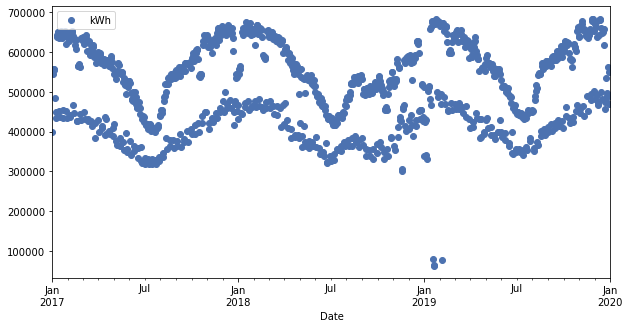

In [3]:
ts.plot(figsize=(10,5),style="o")

In [4]:
import holidays

begin = '2017-01-01'
end = '2019-12-31' # errors within the holidays package
hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:end])

exo = ts.copy()
exo["holidays"] = 0
exo.loc[hol] = 1
exo.loc["2020-01-01","holidays"] = 1

ts["holidays"] = exo["holidays"]
ts

,kWh,holidays
Date,,
2017-01-01,399131.94,1
2017-01-02,545259.57,0
2017-01-03,557400.78,0
2017-01-04,557394.31,0
2017-01-05,554266.71,0
...,...,...
2019-12-28,490973.42,0
2019-12-29,470181.83,0
2019-12-30,550293.99,0


In [5]:
date = ts.index
timestamp_s = date.map(datetime.datetime.timestamp)

In [6]:
week = 7*24*60*60
ts['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
ts['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))

Text(0.5, 1.0, 'Time of week signal')

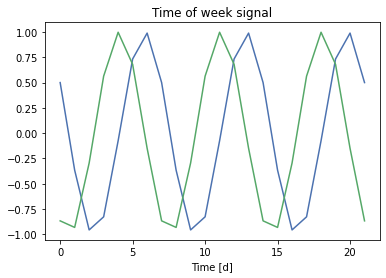

In [7]:
plt.plot(np.array(ts['Week sin'])[:22])
plt.plot(np.array(ts['Week cos'])[:22])

plt.xlabel('Time [d]')
plt.title('Time of week signal')

In [8]:
ts.head(10)

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,399131.94,1,0.500000,-0.866025
2017-01-02,545259.57,0,-0.365341,-0.930874
2017-01-03,557400.78,0,-0.955573,-0.294755
2017-01-04,557394.31,0,-0.826239,0.563320
2017-01-05,554266.71,0,-0.074730,0.997204
2017-01-06,484772.87,1,0.733052,0.680173
2017-01-07,448601.37,0,0.988831,-0.149042
2017-01-08,433151.95,0,0.500000,-0.866025
2017-01-09,638036.96,0,-0.365341,-0.930874


In [9]:
ts.describe()

,kWh,holidays,Week sin,Week cos
count,1096.000000,1096.000000,1096.000000,1096.000000
mean,513641.385976,0.028285,-0.001503,-0.001394
std,101693.964087,0.165861,0.707415,0.707442
min,61980.910000,0.000000,-0.955573,-0.943883
25%,434430.260000,0.000000,-0.826239,-0.846724
50%,519402.665000,0.000000,-0.111964,-0.111964
75%,597521.062500,0.000000,0.707107,0.680173
max,683808.340000,1.000000,0.993712,0.997204


In [10]:
from sklearn.preprocessing import MinMaxScaler

# ts = np.array(ts)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(ts[["kWh"]])
ts_normalized = pd.DataFrame(scaler.fit_transform(ts),
                             columns = ts.columns.values,
                            index = ts.index)

In [11]:
ts_normalized

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,0.542194,1.0,7.467214e-01,0.040110
2017-01-02,0.777191,0.0,3.027940e-01,0.006702
2017-01-03,0.796716,0.0,7.915890e-14,0.334415
2017-01-04,0.796706,0.0,6.634947e-02,0.776474
2017-01-05,0.791676,0.0,4.518799e-01,1.000000
...,...,...,...,...
2019-12-28,0.689890,0.0,9.974958e-01,0.409482
2019-12-29,0.656454,0.0,7.467214e-01,0.040110
2019-12-30,0.785287,0.0,3.027940e-01,0.006702


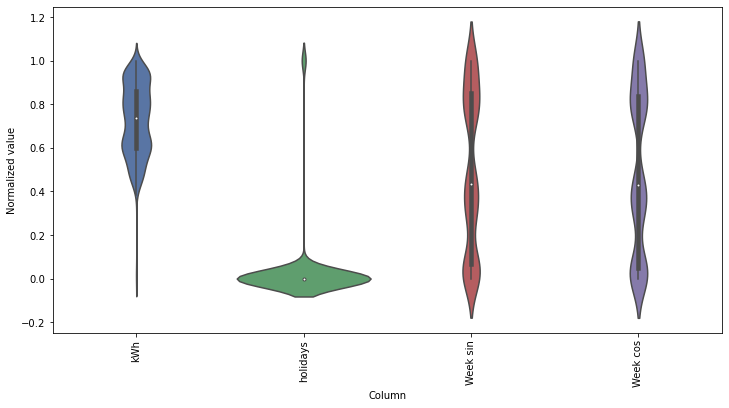

In [12]:
melt_plot = ts_normalized.melt(var_name='Column', value_name='Normalized value')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized value', data=melt_plot)
_ = ax.set_xticklabels(ts_normalized.keys(), rotation=90)

In [13]:
train_end = '2019-12-01'
test_end = '2020-01-01'
demo_start = '2019-11-25'

test_df = ts_normalized[train_end:]
train_val = ts_normalized[:train_end]

n = len(train_val)

train_df = train_val[:int(n*0.8)]
val_df = train_val[int(n*0.8):]


column_indices = {name: i for i, name in enumerate(ts.columns)}
num_features = ts.shape[1]
train_df

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,0.542194,1.0,7.467214e-01,4.011047e-02
2017-01-02,0.777191,0.0,3.027940e-01,6.702214e-03
2017-01-03,0.796716,0.0,7.915890e-14,3.344147e-01
2017-01-04,0.796706,0.0,6.634947e-02,7.764738e-01
2017-01-05,0.791676,0.0,4.518799e-01,1.000000e+00
...,...,...,...,...
2019-04-28,0.532413,0.0,7.631541e-01,5.005398e-02
2019-04-29,0.818335,0.0,3.207811e-01,2.004508e-13
2019-04-30,0.786616,0.0,5.996802e-03,3.161137e-01


In [14]:
import random

def split_sequence(df, fea_width=28, label_width=1, shift=1, label_col_indices=[0], randomize = True):
    
    """ Split sequence with sliding window into
        sequences of context features and target.
        Args:
            source (np.array): Source sequence
            target (np.array): Target sequence
            source_len (int): Length of input sequence.
            target_len (int): Length of target sequence.
            target_start_next (bool): If True, target sequence
                    starts on the next time step of last step of source
                    sequence. If False, target sequence starts at the
                    same time step of source sequence.
        Return:
            X (np.array): sequence of features
            y (np.array): sequence of targets
    """
    arr = df.to_numpy()

    # Work out the label column indices.

    window_size = fea_width + shift + label_width - 1
    fea_slice = slice(0, fea_width)
    fea_indices = np.arange(window_size)[fea_slice]

    label_slice = slice(window_size - label_width, None)
    label_indices = np.arange(window_size)[label_slice]
    
    
    print("\n window_size: {} \n fea_indices: {} \n label_indices: {}"
          .format(window_size,fea_indices,label_indices))
    
    
    def split_window(window):
        features = window[fea_slice]
        labels = window[label_slice]
#         print(label_col)
#         print([label_col_indices[name] for name in label_col])
        if label_col_indices is not None:
            labels = np.stack(
                [labels[:, label_col_indices[idx]] 
                 for idx in label_col_indices],
                axis=-1)
        
        labels = labels.flatten()
        
        return features, labels
            
    n = len(arr)
    X,y = list(),list()
    for i in range(0, n, shift):
        
        window = arr[i:i+window_size]
        if (len(window) != window_size): break
        
        # Find the end of this pattern:
        features,labels = split_window(window)
        X.append(features)
        y.append(labels)
        
#     print(label_col_indices)
#     if randomize == True:
#         random.shuffle(X)
#         random.shuffle(y)
    
    return X,y

In [15]:
fea_width, label_width, shift, label_col_indices = 28, 1, 1, [0]

X_ts,y_ts = split_sequence(ts_normalized,randomize=False)

X_train,y_train = split_sequence(train_df)
X_val,y_val = split_sequence(val_df)
X_test,y_test = split_sequence(test_df)

X_train[0].shape,y_train[0].shape


 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]


((28, 4), (1,))

In [16]:
def to_tensor(ls):
    return Variable(torch.cuda.FloatTensor(np.array(ls)))

X_ts,y_ts = to_tensor(X_ts),to_tensor(y_ts)

X_train,y_train = to_tensor(X_train),to_tensor(y_train)
X_val,y_val = to_tensor(X_val),to_tensor(y_val)
X_test,y_test = to_tensor(X_test),to_tensor(X_test)

X_train

tensor([[[5.4219e-01, 1.0000e+00, 7.4672e-01, 4.0110e-02],
         [7.7719e-01, 0.0000e+00, 3.0279e-01, 6.7022e-03],
         [7.9672e-01, 0.0000e+00, 7.9159e-14, 3.3441e-01],
         ...,
         [9.3904e-01, 0.0000e+00, 4.5188e-01, 1.0000e+00],
         [8.9637e-01, 0.0000e+00, 8.6628e-01, 8.3667e-01],
         [6.2653e-01, 0.0000e+00, 9.9750e-01, 4.0948e-01]],

        [[7.7719e-01, 0.0000e+00, 3.0279e-01, 6.7022e-03],
         [7.9672e-01, 0.0000e+00, 7.9159e-14, 3.3441e-01],
         [7.9671e-01, 0.0000e+00, 6.6349e-02, 7.7647e-01],
         ...,
         [8.9637e-01, 0.0000e+00, 8.6628e-01, 8.3667e-01],
         [6.2653e-01, 0.0000e+00, 9.9750e-01, 4.0948e-01],
         [6.0036e-01, 0.0000e+00, 7.4672e-01, 4.0110e-02]],

        [[7.9672e-01, 0.0000e+00, 7.9159e-14, 3.3441e-01],
         [7.9671e-01, 0.0000e+00, 6.6349e-02, 7.7647e-01],
         [7.9168e-01, 0.0000e+00, 4.5188e-01, 1.0000e+00],
         ...,
         [6.2653e-01, 0.0000e+00, 9.9750e-01, 4.0948e-01],
         [

In [17]:
from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
from torch.autograd import Variable

import torch
import torch
import torch.nn as nn

In [18]:
# class LSTM(nn.Module):

#     def __init__(self, num_classes, input_size, hidden_size, num_layers):
#         super(LSTM, self).__init__()
        
#         self.num_classes = num_classes
#         self.num_layers = num_layers
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         #self.seq_length = seq_length
#         self.dropout = nn.Dropout(p=0.2)
        
#         self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
#                             num_layers=num_layers, batch_first=True,dropout = 0.25)
        
#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         h_0 = Variable(torch.zeros(
#             self.num_layers, x.size(0), self.hidden_size).cuda())
        
#         c_0 = Variable(torch.zeros(
#             self.num_layers, x.size(0), self.hidden_size).cuda())
        
#         # Propagate input through LSTM
#         ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
#         h_out = h_out.view(-1, self.hidden_size)
        
#         out = self.fc(h_out)
#         out = self.dropout(out)
       
#         return out
    
# # create a nn class (just-for-fun choice :-) 
# class RMSELoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.mse = nn.MSELoss()
        
#     def forward(self,yhat,y):
#         return torch.sqrt(self.mse(yhat,y))
    
# #####  Parameters  ######################
# num_epochs = 20
# learning_rate = 1e-3
# input_size = 4
# hidden_size = 100
# num_layers = 1
# num_classes = 1

# #####Init the Model #######################
# model = LSTM(num_classes, input_size, hidden_size, num_layers)
# model.cuda()

# ##### Set Criterion Optimzer and scheduler ####################
# criterion = torch.nn.MSELoss().cuda()    # mean-squared error for regression
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)

C:\Users\Admin\.conda\envs\energy1\lib\site-packages\torch\nn\modules\rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [39]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
       
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
num_epochs = 700
learning_rate = 1e-3
input_size = 4
hidden_size = 512
num_layers = 2

num_classes = 1

model = LSTM2(num_classes, input_size, hidden_size, num_layers)
model.cuda()


model.apply(init_weights)

criterion = torch.nn.MSELoss().cuda()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [40]:
# import torch.nn as nn

# class LSTM(nn.Module):
#     def __init__(self, input_size=4, hidden_layer_size=20, output_size=1):
#         super().__init__()
#         self.hidden_layer_size = hidden_layer_size

#         self.lstm = nn.LSTM(input_size, hidden_layer_size)

#         self.linear = nn.Linear(hidden_layer_size, output_size)

#         self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).cuda(),
#                             torch.zeros(1,1,self.hidden_layer_size).cuda())

#     def forward(self, input_seq):
#         lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
#         predictions = self.linear(lstm_out.view(len(input_seq), -1))
#         return predictions[-1]
    
# model = LSTM()

# model.cuda()
# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [41]:
num_epochs = 300

for epoch in progress_bar(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    
    loss = torch.sqrt(criterion(y_pred, y_train))
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    valid = model(X_val)
    val_loss = torch.sqrt(criterion(valid, y_val))
    scheduler.step(val_loss)
    
    if epoch%3 == 1:
        print("Epoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

print("Final: \nEpoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

Epoch: 1, loss: 0.18451 validation loss:  1.03485 
Epoch: 4, loss: 0.19513 validation loss:  0.29758 
Epoch: 7, loss: 0.29852 validation loss:  0.23094 
Epoch: 10, loss: 0.18610 validation loss:  0.21483 
Epoch: 13, loss: 0.15601 validation loss:  0.14796 
Epoch: 16, loss: 0.18172 validation loss:  0.16258 
Epoch: 19, loss: 0.14272 validation loss:  0.13121 
Epoch: 22, loss: 0.15392 validation loss:  0.12837 
Epoch: 25, loss: 0.13288 validation loss:  0.12513 
Epoch: 28, loss: 0.13109 validation loss:  0.11139 
Epoch: 31, loss: 0.12602 validation loss:  0.11343 
Epoch: 34, loss: 0.11896 validation loss:  0.10899 
Epoch: 37, loss: 0.12176 validation loss:  0.10519 
Epoch: 40, loss: 0.11747 validation loss:  0.10038 
Epoch: 43, loss: 0.11162 validation loss:  0.09602 
Epoch: 46, loss: 0.10751 validation loss:  0.08388 
Epoch: 49, loss: 0.10601 validation loss:  0.07533 
Epoch: 52, loss: 0.10800 validation loss:  0.07727 
Epoch: 55, loss: 0.10330 validation loss:  0.08182 
Epoch: 58, loss

In [42]:
model.eval()
y_pred = model(X_ts).cpu().detach().numpy()
y_obs = y_ts.cpu().numpy()

## Inverse Normalize 
y_pred = scaler_kwh.inverse_transform(y_pred)
y_obs = scaler_kwh.inverse_transform(y_obs)
y_pred[:10]

array([[460837.44],
       [620520.44],
       [630168.1 ],
       [626180.9 ],
       [633189.7 ],
       [608151.75],
       [463769.2 ],
       [430601.53],
       [606614.56],
       [629441.44]], dtype=float32)

In [43]:
pred_df = pd.DataFrame(y_pred,index = ts.index[-len(y_pred):],columns = ["kWh"])
obs_df = pd.DataFrame(y_obs,index = ts.index[-len(y_pred):],columns = ["kWh"])

plot_df = pd.concat([obs_df,pred_df],axis=1)

<AxesSubplot:xlabel='Date'>

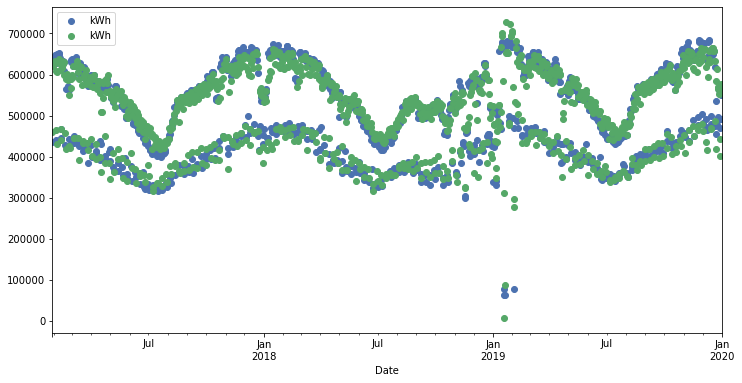

In [44]:
plot_df.plot(figsize=(12,6),style = 'o')

<AxesSubplot:xlabel='Date'>

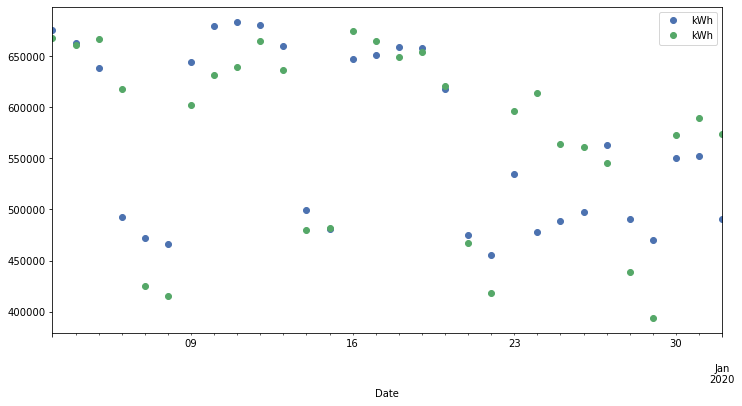

In [37]:
plot_df.iloc[-30:].plot(figsize=(12,6),style = 'o')